In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
###imports###
import numpy as np
import tensorflow as tf
import scipy.io
from scipy import io
import sys
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.python.framework import graph_util
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
import pickle
import datetime
import time
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import OneHotEncoder
import logging
import skimage.io
import random
import PIL
from pathlib import Path

In [6]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [8]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [9]:
#makes all outputs be in float format rather than exponentials
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [10]:
#Set Parameters
IMG_SIZE = 224
DATE = datetime.datetime.now().strftime('%d-%b-%Y')
MODEL_PATH = f'models/{DATE}/'
MODEL_NAME = 'FlowerClassifierTrial.model'.format(int(time.time()))
log_dir=f'logs\\{MODEL_NAME}'
TENSORBOARD = TensorBoard(log_dir=f'logs\\{MODEL_NAME}')

In [11]:
###Directory for PC
labels_dir = 'E:/Github/thesis/flowerDataset/imagelabels.mat'
URL = 'E:/Github/thesis/flowerDataset/grabcut'
dataSplit = 'E:/Github/thesis/flowerDataset/setid.mat'
loaded_images_dir = 'E:/Dissertation/GrabCutloaded_images.npy'
image_train_dir = 'E:/Dissertation/GCimage_train.npy'
label_train_dir = 'E:/Dissertation/label_train.npy'
image_test_dir = 'E:/Dissertation/GCimage_test.npy'
label_test_dir = 'E:/Dissertation/label_test.npy'
image_val_dir = 'E:/Dissertation/GCimage_val.npy'
label_val_dir = 'E:/Dissertation/GClabel_val.npy'

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# labels


# Load in Images for GrabCut


In [13]:
#gets all the image paths stores in a list
def get_img_paths(URL):
    img_paths = []
    for path in os.listdir(URL_dir):
        full_path = os.path.join(URL_dir, path)
        if os.path.isfile(full_path):
            img_paths.append(full_path)

    return img_paths

In [14]:
#img_paths = get_img_paths(URL)

In [15]:
def grab_cut(img_paths): #grab cut algorithm used to created segmented flower images WARNING: very time consuming
    for i in range(len(img_paths)):
        img = cv2.imread(img_paths[i])
        name = Path(img_paths[i]).stem
        loc = 'E:/Github/thesis/flowerDataset/grabcut/'
        mask = np.zeros(img.shape[:2], np.uint8)

        bgdModel = np.zeros((1,65), np.float64)
        fgdModel = np.zeros((1,65), np.float64)
        rect = (10,5,650,650)

        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        img = img*mask2[:,:,np.newaxis]

        cv2.imwrite(loc+ name + '.jpg', img)

    

In [16]:
#grab_cut(img_paths)

In [17]:
#Got loading files code from link below
#https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
#Function gets all the images loaded up
def load_images_from_folder(URL):
    images = []
    for filename in os.listdir(URL):
        #img = cv2.imread(os.path.join(URL,filename))
        img = cv2.resize(cv2.imread(os.path.join(URL,filename), cv2.COLOR_BGR2RGB), (IMG_SIZE, IMG_SIZE))
        img = np.reshape(img,[IMG_SIZE,IMG_SIZE,3])
        if img is not None:
            images.append(img)
    np.save(loaded_images_dir, images)
    return images

In [18]:
#No need to run this cell if image already loaded.
load_images_from_folder(URL)

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
      

In [19]:
image_data = np.load(loaded_images_dir, allow_pickle=True)

In [20]:
image_data.shape

(8189, 224, 224, 3)

In [21]:
data_labels = io.loadmat(labels_dir)
data_labels = data_labels.items()
data_labels = list(data_labels)

In [22]:
df = pd.DataFrame(data_labels)

In [23]:
labels = df[1][3][0] #loads the labels that is stored in dataframe format

In [24]:
labels

array([77, 77, 77, ..., 62, 62, 62], dtype=uint8)

In [25]:
# Label Encoder

mlb = LabelBinarizer()
labels = np.array(mlb.fit_transform(labels))

In [26]:
labels.shape

(8189, 102)

In [27]:
#citation code from https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
#splitting the image dataset into the ratio for training, validation adn testing data
def split_data(image_data, labels):
    
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    image_train, image_test, label_train, label_test = train_test_split(image_data, labels, test_size=1 - train_ratio)

    #the test from previous line which is 25% of dataset is passed into the line below to be 
    #further split into 15% for validation and 10% for testing

    image_val, image_test, label_val, label_test = train_test_split(image_test, label_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

    print('image_train',image_train.shape)
    print('label_train',label_train.shape)
    print('image_test',image_test.shape)
    print('label_test',label_test.shape)
    print('image_val', image_val.shape)
    print('label_val', label_val.shape)

    np.save(image_train_dir, image_train)
    np.save(label_train_dir, label_train)
    np.save(image_test_dir, image_test)
    np.save(label_test_dir, label_test)
    np.save(image_val_dir, image_val)
    np.save(label_val_dir, label_val)


In [28]:
split_data(image_data,labels)

image_train (6141, 224, 224, 3)
label_train (6141, 102)
image_test (820, 224, 224, 3)
label_test (820, 102)
image_val (1228, 224, 224, 3)
label_val (1228, 102)


In [29]:
image_train = np.load(image_train_dir, allow_pickle=True)
image_test = np.load(image_test_dir, allow_pickle=True)
label_train = np.load(label_train_dir, allow_pickle=True)
label_test = np.load(label_test_dir, allow_pickle=True)
image_val = np.load(image_val_dir, allow_pickle=True)
label_val = np.load(label_val_dir, allow_pickle=True)

# Feature scaling

In [30]:
#converts the images to the range of 0 - 1.0 
image_train = image_train/255.0
image_test = image_test/255.0
image_val = image_val/255.0

In [31]:
# number of classes/ flowers
NUM_CLASSES = 102
NUM_CLASSES

102

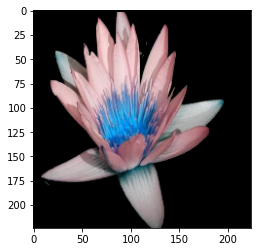

In [35]:
img = image_train[0]
plt.imshow(img)

# Model 

In [36]:
# name of model
name_model = 'GC-{}'.format(int(time.time()))

In [37]:
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(name_model))

In [38]:
batch_size = 32
epochs = 100
verbose= 2
act = 'relu'

In [39]:
def create_cnn_model(act, verbose):
    model = Sequential()
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    # INPUT LAYER
    model.add(Conv2D(32, (3, 3), activation=act, input_shape=input_shape))
    ## model.add(MaxPooling2D(pool_size=(2,2)))

    # HIDDEN LAYER 1
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation(act))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # HIDDEN LAYER 2
    model.add(Conv2D(64, (3, 3), activation=act))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 3
    model.add(Conv2D(128, (3, 3), activation=act))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 4
    model.add(Conv2D(256, (3, 3), activation=act))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # Fully Connected
    model.add(Flatten()) # converts the 3D feature maps to 1D feature vectors
    model.add(Dense(256))
    model.add(Dropout(0.25)) # reduces overfitting

    # OUTPUT LAYER
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [40]:
model = create_cnn_model(act, verbose)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
activation (Activation)      (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 110, 110, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

# Evaluation

In [42]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [44]:
EXPERIMENT_NAME = "custom-model-tests"
RUN_NAME = "grab_cut"

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.set_tracking_uri('file:///E:/GoogleSync/Masters/Dissertation/MLflow/mlruns')

with mlflow.start_run(run_name=RUN_NAME) as run:
        
        mlflow.tensorflow.autolog()
        
        history = model.fit(image_train, label_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(image_val, label_val), callbacks=[tensorboard_callback])

        score = model.evaluate(image_test, label_test, batch_size=batch_size, verbose = verbose)
        
        
        
    
        
        mlflow.log_param("activation function", act)
        mlflow.log_metric("test loss", score[0])
        mlflow.log_metric("test accuracy", score[1])
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        
        
        
        #tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        #mlflow.keras.log_model(model, "standardCNN")        

2021/08/14 22:15:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/100


192/192 - 67s - loss: 25.4028 - accuracy: 0.0850 - val_loss: 44.2164 - val_accuracy: 0.0236
Epoch 2/100
192/192 - 7s - loss: 15.2939 - accuracy: 0.2666 - val_loss: 25.2773 - val_accuracy: 0.0603
Epoch 3/100
192/192 - 7s - loss: 6.8290 - accuracy: 0.4830 - val_loss: 13.0818 - val_accuracy: 0.1881
Epoch 4/100
192/192 - 7s - loss: 3.0725 - accuracy: 0.6823 - val_loss: 8.3671 - val_accuracy: 0.3599
Epoch 5/100
192/192 - 7s - loss: 1.5926 - accuracy: 0.7984 - val_loss: 7.9964 - val_accuracy: 0.3966
Epoch 6/100
192/192 - 7s - loss: 0.8520 - accuracy: 0.8722 - val_loss: 8.0938 - val_accuracy: 0.4226
Epoch 7/100
192/192 - 7s - loss: 0.6379 - accuracy: 0.8976 - val_loss: 7.4716 - val_accuracy: 0.4088
Epoch 8/100
192/192 - 7s - loss: 0.4220 - accuracy: 0.9212 - val_loss: 7.9711 - val_accuracy: 0.4047
Epoch 9/100
192/192 - 7s - loss: 0.3138 - accuracy: 0.9427 - val_loss: 8.5305 - val_accuracy: 0.4300
Epoch 10/100
192/192 - 7s - loss: 0.3769 - accuracy: 0.9323 - val_loss: 8.4506 - val_accuracy: 0.

Epoch 81/100
192/192 - 7s - loss: 0.0460 - accuracy: 0.9906 - val_loss: 17.3979 - val_accuracy: 0.3746
Epoch 82/100
192/192 - 7s - loss: 0.0593 - accuracy: 0.9917 - val_loss: 18.7974 - val_accuracy: 0.3664
Epoch 83/100
192/192 - 7s - loss: 0.0622 - accuracy: 0.9920 - val_loss: 16.6838 - val_accuracy: 0.3518
Epoch 84/100
192/192 - 7s - loss: 0.0564 - accuracy: 0.9914 - val_loss: 17.9843 - val_accuracy: 0.3542
Epoch 85/100
192/192 - 7s - loss: 0.0911 - accuracy: 0.9876 - val_loss: 19.4599 - val_accuracy: 0.3689
Epoch 86/100
192/192 - 7s - loss: 0.0986 - accuracy: 0.9876 - val_loss: 17.3099 - val_accuracy: 0.3339
Epoch 87/100
192/192 - 7s - loss: 0.0540 - accuracy: 0.9922 - val_loss: 19.7951 - val_accuracy: 0.3428
Epoch 88/100
192/192 - 7s - loss: 0.0606 - accuracy: 0.9922 - val_loss: 17.3791 - val_accuracy: 0.3860
Epoch 89/100
192/192 - 7s - loss: 0.0392 - accuracy: 0.9923 - val_loss: 19.6540 - val_accuracy: 0.3542
Epoch 90/100
192/192 - 7s - loss: 0.0402 - accuracy: 0.9914 - val_loss: 1

INFO:tensorflow:Assets written to: C:\Users\yisi9\AppData\Local\Temp\tmpmoe3ipx3\model\data\model\assets


26/26 - 1s - loss: 19.8486 - accuracy: 0.3646


In [39]:
%load_ext tensorboard
%tensorboard --logdir=logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12888), started 1:17:06 ago. (Use '!kill 12888' to kill it.)

In [40]:
# http://localhost:5000/

In [41]:
model.evaluate(image_test, label_test, verbose = 0)

[14.363236427307129, 0.42073169350624084]